# Time Series Forecasting for Multiple Parallel Input and Multi-step Output

Based on https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [50]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [51]:
# JSON file
json_file = "dataset/kitchen-data.json"

# Convert JSON to pandas dataframe
json_data = pd.read_json(json_file, orient='split')
dataset = json_data.transpose()
# dataset['timestamp'] = pd.to_datetime(dataset['timestamp'], unit='s')

# Drop incomplete rows
dataset = dataset.dropna(axis=0)
# Drop first column
dataset.reset_index(drop=True, inplace=True)

print(dataset.head())
print(dataset.shape)

dataset.to_csv("dataset/kitchen-dataset.csv")

     CO_PPM  humidity  temperature     timestamp
0  10.95994      49.0         22.8  1.645978e+09
1  11.74180      49.0         22.8  1.645978e+09
2  12.02302      50.0         22.7  1.645978e+09
3  12.09442      51.0         22.7  1.645978e+09
4  12.02302      51.0         22.7  1.645978e+09
(9846, 4)


### Split (and normalize) the data

In [52]:
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('dataset/kitchen-dataset.csv')

# Remove first column (index column)
dataset = dataset.iloc[: , 1:]
dataset.drop('timestamp', axis=1, inplace=True)
# dataset.index.name = 'timestamp'

# time_index = np.array(dataset['timestamp'])

# Split the data
RANDOM_SEED = 101
TEST_SIZE = 0.2 

x_train, x_test = train_test_split(dataset, 
    test_size=TEST_SIZE, 
    random_state = RANDOM_SEED)
x_train = x_train.values
x_test  = x_test.values

print('Training data size   :', x_train.shape)
print('Validation data size :', x_test.shape)

Training data size   : (7876, 3)
Validation data size : (1970, 3)


In [62]:
# Normalize the data to give equal importance to features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

In [63]:
# split a multivariate sequence into samples
def split_series(sequences, n_past, n_future):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_past
		out_end_ix = end_ix + n_future
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [64]:
# Time step and features variable
n_past = 100
n_future = 50
n_features = 3

In [65]:
# convert both the train and test data into samples using the split_series function
X_train, y_train = split_series(x_train, n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(x_test,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

### Construct the model

In [66]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# define model
model = Sequential()
# model.add(LSTM(200, activation='relu', input_shape=(n_past, n_features)))
model.add(LSTM(50, activation='relu', input_shape=(n_past, n_features)))
model.add(RepeatVector(n_future))
# model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

model.compile(optimizer='adam', loss='mse')

# fit model
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model.fit(X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr])

Epoch 1/10
242/242 [==============================] - 36s 115ms/step - loss: 0.0261 - val_loss: 0.0205 - lr: 0.0010
Epoch 2/10
242/242 [==============================] - 21s 85ms/step - loss: 0.0200 - val_loss: 0.0200 - lr: 9.0000e-04
Epoch 3/10
242/242 [==============================] - 20s 83ms/step - loss: 0.0197 - val_loss: 0.0199 - lr: 8.1000e-04
Epoch 4/10
242/242 [==============================] - 14s 58ms/step - loss: 0.0197 - val_loss: 0.0198 - lr: 7.2900e-04
Epoch 5/10
242/242 [==============================] - 14s 57ms/step - loss: 0.0196 - val_loss: 0.0198 - lr: 6.5610e-04
Epoch 6/10
242/242 [==============================] - 17s 71ms/step - loss: 0.0196 - val_loss: 0.0199 - lr: 5.9049e-04
Epoch 7/10
242/242 [==============================] - 14s 56ms/step - loss: 0.0196 - val_loss: 0.0198 - lr: 5.3144e-04
Epoch 8/10
242/242 [==============================] - 15s 60ms/step - loss: 0.0196 - val_loss: 0.0198 - lr: 4.7830e-04
Epoch 9/10
242/242 [==============================]

### Prediction

In [67]:
# demonstrate prediction
predictions = model.predict(X_test, verbose=0)
print(predictions)

[[[0.1064267  0.33097455 0.37281096]
  [0.10458103 0.34436095 0.39318353]
  [0.10301789 0.33825088 0.38995743]
  ...
  [0.10389186 0.33762586 0.38782406]
  [0.10389185 0.33762586 0.38782406]
  [0.10389183 0.33762586 0.38782403]]

 [[0.10644111 0.33102718 0.37363803]
  [0.10479936 0.34428996 0.39369476]
  [0.1033992  0.33811307 0.39024112]
  ...
  [0.10433649 0.33744347 0.38785324]
  [0.10433643 0.33744347 0.3878532 ]
  [0.10433641 0.33744347 0.3878532 ]]

 [[0.10584801 0.329917   0.37305027]
  [0.10435459 0.34359872 0.39327428]
  [0.10304424 0.33754772 0.38971257]
  ...
  [0.10421225 0.3372584  0.3873302 ]
  [0.10421224 0.33725837 0.38733017]
  [0.10421224 0.33725837 0.38733017]]

 ...

 [[0.10403515 0.32406908 0.36758402]
  [0.10385467 0.341882   0.3932804 ]
  [0.10281681 0.33724773 0.39143816]
  ...
  [0.10430664 0.3372355  0.3890343 ]
  [0.10430662 0.3372355  0.38903427]
  [0.10430662 0.3372355  0.38903427]]

 [[0.10375243 0.3244745  0.36834618]
  [0.10352029 0.34230188 0.39348745]


(1821,)
(1970,)


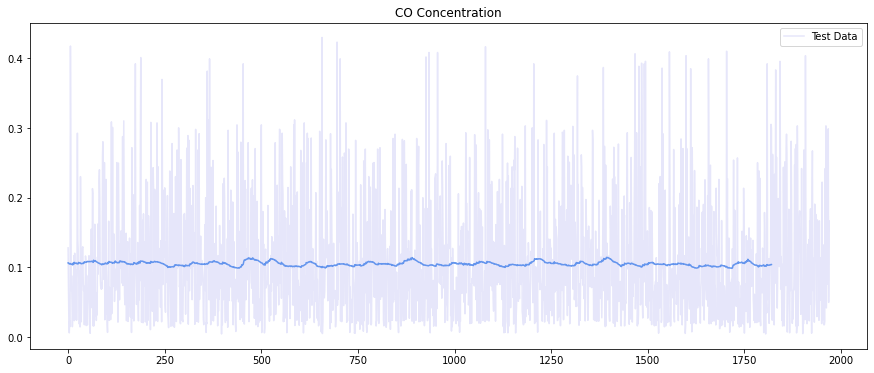

In [83]:
print(predictions[:,0,0].shape)
print(x_test[:,0].shape)

plt.figure(figsize=(15, 6))
plt.title('CO Concentration')
plt.plot(x_test[:,0], c='lavender', label='Test Data')
plt.plot(predictions[:,0,0], c='cornflowerblue')
# plt.plot(pred_e1d1[:,:,0], c='royalblue')
plt.legend(loc='best')
